In [9]:
# Font size
from IPython.core.display import HTML
small = (1, 1, 9, 11)
large = (1.8, 1.2, 12, 14)
HTML("""
<style>

div.text_cell_render {{
    font-size: {}em;
    line-height: {}em;
}}

.CodeMirror pre {{
    font-size: {}pt;
    line-height: {}pt;
}}

</style>
""".format(*small))

# Advanced Numpy Techniques

<img src="assets/numpylogo.png" alt="http://www.numpy.org/#">

General, user-friendly [documentation](https://docs.scipy.org/doc/numpy/index.html) with lots of examples.

Technical, "hard" [reference](https://docs.scipy.org/doc/numpy/reference/index.html#reference).

Dataquest [cheat sheet](https://www.dataquest.io/blog/images/cheat-sheets/numpy-cheat-sheet.pdf).

Basic Python knowledge assumed, see [here](https://github.com/ASvyatkovskiy/PythonWorkshop/blob/Spring2017/1_PythonBasics/PythonBasics.ipynb).

CPython ~3.6, NumPy ~1.12

## What is it?

[NumPy](http://www.numpy.org/) is an open-source package that's part of the [SciPy](https://scipy.org/) ecosystem. Its main feature is an array object of arbitrary dimension, but this fundamental collection is integral to any data-focused Python application.


<table>
<tr>
<th>
<img src="assets/nonsteeplearn.png" width="200" alt="http://gabriellhanna.blogspot.com/2015/03/negatively-accelerated-learning-curve-i.html">
</th><th>
<img src="assets/steeplearn.jpg" width="200" alt="http://malaher.org/2007/03/pet-peeve-learning-curve-misuse/">
</th></tr></table>

Most people learn numpy through assimilation or necessity. I believe NumPy has the latter learning curve (steep/easy to learn), so you can actually invest just a little bit of time now (by going through this notebook, for instance), and reap a lot of reward!

# Motivation

* Provide a uniform interface for handling numerical structured data
* Collect, store, and manipulate numerical data efficiently
* Low-cost abstractions
* Universal glue for numerical information, used in lots of external libraries!


<table>
<tr>
<th>
<img src="assets/numba.png" alt="http://numba.pydata.org/" width="150"></th><th><img src="assets/pandas.png" alt="http://pandas.pydata.org/"  width="150"> </th><th><img src="assets/tf.png" alt="https://github.com/tensorflow/tensorflow" width="150"></th><th> <img src="assets/sklearn.png" alt="https://github.com/scikit-learn/scikit-learn" width="150"> </th><th><img src="assets/stan.png" alt="http://mc-stan.org/" width="150"></th>
</tr>
</table>



# Goals and Non-goals

### Goals

What I'll do:

* Give a bit of basics first.
* Describe NumPy, with under-the-hood details to the extent that they are useful to you, the user
* Highlight some [GOTCHA]s, avoid some common bugs
* Point out a couple useful NumPy functions

**This is not an attempt to exaustively cover the reference manual (there's too many individual functions to keep in your head, anyway).**

Instead, I'll try to...

* provide you with an overview of the API structure so next time you're doing numeric data work you'll know where to look
* convince you that NumPy arrays offer the perfect data structure for the following (wide-ranging) use case:

**RAM-sized general-purpose structured numerical data applications: manipulation, collection, and analysis.**

### Non-goals

* No emphasis on multicore processing, but will be briefly mentioned
* Some NumPy functionality not covered -- mentioned briefly at end
* HPC concerns
* GPU programming

# Why not a Python list?

A list is a resizing contiguous array of pointers.

<img src="assets/pylist.png" alt="http://www.laurentluce.com/posts/python-list-implementation/">

Nested lists are even worse - there are two levels of indirection.

<img src="assets/nestlist.png" alt="http://www.cs.toronto.edu/~gpenn/csc401/401_python_web/pyseq.html">

Imagine we're trying to apply a read or write operation over these arrays on our modern CPU:

<img src="assets/vecproc.gif" alt="http://www.netlib.org/utk/papers/advanced-computers_2004_10_14/sm-simd.html">

Compare to NumPy arrays:

<img src="assets/nparr.png" alt="https://www.safaribooksonline.com/library/view/python-for-data/9781491957653/ch04.html" width=300>

**Recurring theme**: NumPy lets us have the best of both worlds (high-level Python for development, optimized representation and speed via low-level C routines for execution)

In [6]:
import numpy as np
import time
import gc
import sys

assert sys.maxsize > 2 ** 32, "get a new computer!"

# Allocation-sensitive timing needs to be done more carefully
# Compares runtimes of f1, f2
def compare_times(f1, f2, setup1=None, setup2=None, runs=5):
    print('    format: mean seconds (standard error)', runs, 'runs')
    maxpad = max(len(f.__name__) for f in (f1, f2))
    means = []
    for setup, f in [[setup1, f1], [setup2, f2]]:
        setup = (lambda: tuple()) if setup is None else setup
        
        total_times = []
        for _ in range(runs):
            try:
                gc.disable()
                args = setup()
                
                start = time.time()
                if isinstance(args, tuple):
                    f(*args)
                else:
                    f(args)
                end = time.time()
                
                total_times.append(end - start)
            finally:
                gc.enable()
                
        mean = np.mean(total_times)
        se = np.std(total_times) / np.sqrt(len(total_times))
        print('    {} {:.2e} ({:.2e})'.format(f.__name__.ljust(maxpad), mean, se))
        means.append(mean)
    print('    improvement ratio {:.1f}'.format(means[0] / means[1]))

### Bandwidth-limited ops

* Have to pull in more cache lines for the pointers
* Poor locality causes pipeline stalls

In [7]:
size = 10 ** 7 # ints will be un-intered past 258
print('create a list 1, 2, ...', size)


def create_list(): return list(range(size))
def create_array(): return np.arange(size, dtype=int)

compare_times(create_list, create_array)

create a list 1, 2, ... 10000000
    format: mean seconds (standard error) 5 runs
    create_list  2.98e-01 (8.21e-03)
    create_array 2.01e-02 (5.41e-04)
    improvement ratio 14.8


In [4]:
print('deep copies (no pre-allocation)') # Shallow copy is cheap for both!
size = 10 ** 7

ls = list(range(size))
def copy_list(): return ls[:]

ar = np.arange(size, dtype=int)
def copy_array(): return np.copy(ar)

compare_times(copy_list, copy_array)

deep copies (no pre-allocation)
    format: mean seconds (standard error) 5 runs
    copy_list  8.17e-02 (2.40e-03)
    copy_array 1.47e-02 (3.51e-04)
    improvement ratio 5.5


In [5]:
print('Deep copy (pre-allocated)')
size = 10 ** 7

def create_lists(): return list(range(size)), [0] * size
def deep_copy_lists(src, dst): dst[:] = src

def create_arrays(): return np.arange(size, dtype=int), np.empty(size, dtype=int)
def deep_copy_arrays(src, dst): dst[:] = src

compare_times(deep_copy_lists, deep_copy_arrays, create_lists, create_arrays)

Deep copy (pre-allocated)
    format: mean seconds (standard error) 5 runs
    deep_copy_lists  7.92e-02 (2.13e-03)
    deep_copy_arrays 1.49e-02 (5.10e-04)
    improvement ratio 5.3


### Flop-limited ops

* Can't engage VPU on non-contiguous memory: won't saturate CPU computational capabilities of your hardware.

In [6]:
print('square out-of-place')

def square_lists(src, dst):
    for i, v in enumerate(src):
        dst[i] = v * v

def square_arrays(src, dst):
    np.square(src, out=dst)
    
compare_times(square_lists, square_arrays, create_lists, create_arrays)

square out-of-place
    format: mean seconds (standard error) 5 runs
    square_lists  9.98e-01 (2.55e-02)
    square_arrays 1.58e-02 (1.42e-03)
    improvement ratio 63.2


In [7]:
# Caching and SSE can have huge cumulative effects

print('square in-place')
size = 10 ** 7

def create_list(): return list(range(size))
def square_list(ls):
    for i, v in enumerate(ls):
        ls[i] = v * v

def create_array(): return np.arange(size, dtype=int)
def square_array(ar):
    np.square(ar, out=ar)
    
compare_times(square_list, square_array, create_list, create_array)

square in-place
    format: mean seconds (standard error) 5 runs
    square_list  9.72e-01 (4.10e-02)
    square_array 8.17e-03 (1.25e-04)
    improvement ratio 119.0


### Memory consumption

List representation uses 8 extra bytes for every value (assuming 64-bit here and henceforth)!

In [8]:
from pympler import asizeof
size = 10 ** 4

print('list  kb', asizeof.asizeof(list(range(size))) // 1024)
print('array kb', asizeof.asizeof(np.arange(size, dtype=int)) // 1024)

list  kb 400
array kb 78


### Disclaimer

Regular python lists are still useful! They do a lot of things arrays can't:

* List comprehensions `[x * x for x in range(10) if x % 2 == 0]`
* Ragged nested lists `[[1, 2, 3], [1, [2]]]`

# The NumPy Array

[doc](https://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html#internal-memory-layout-of-an-ndarray)

### Abstraction

We know what an array is -- a contiugous chunk of memory holding an indexed list of things from 0 to its size minus 1. If the things have a particular type, using, say, `dtype` as a placeholder, then we can refer to this as a `classical_array` of `dtype`s.

The NumPy array, an `ndarray` with a _datatype, or dtype,_ `dtype` is an _N_-dimensional array for arbitrary _N_. This is defined recursively:
* For _N > 0_, an _N_-dimensional `ndarray` of _dtype_ `dtype` is a `classical_array` of _N - 1_ dimensional `ndarray`s of _dtype_ `dtype`, all with the same size.
* For _N = 0_, the `ndarray` is a `dtype`

We note some familiar special cases:
* _N = 0_, we have a scalar, or the datatype itself
* _N = 1_, we have a `classical_array`
* _N = 2_, we have a matrix

Each _axis_ has its own `classical_array` length: this yields the shape.

In [9]:
n0 = np.array(3, dtype=float)
n1 = np.stack([n0, n0, n0, n0])
n2 = np.stack([n1, n1])
n3 = np.stack([n2, n2])

for x in [n0, n1, n2, n3]:
    print('ndim', x.ndim, 'shape', x.shape)
    print(x)

ndim 0 shape ()
3.0
ndim 1 shape (4,)
[ 3.  3.  3.  3.]
ndim 2 shape (2, 4)
[[ 3.  3.  3.  3.]
 [ 3.  3.  3.  3.]]
ndim 3 shape (2, 2, 4)
[[[ 3.  3.  3.  3.]
  [ 3.  3.  3.  3.]]

 [[ 3.  3.  3.  3.]
  [ 3.  3.  3.  3.]]]


**Axes are read LEFT to RIGHT: an array of shape `(n0, n1, ..., nN-1)` has axis `0` with length `n0`, etc.**

### Detour: Formal Representation

Formally, a NumPy array can be viewed as a mathematical object. If:

* The `dtype` belongs to some set $F$
* The array has dimension $N$, with the $i$-th axis having length $n_i$
* $N>1$

Then this array is an object in:

$$
F^{n_0}\otimes F^{n_{1}}\otimes\cdots \otimes F^{n_{N-1}}
$$

$F^n$ is an $n$-dimensional vector field over $F$. An element in here can be represented by its canonical basis $\textbf{e}_i^{(n)}$ as a sum for elements $f_i\in F$:

$$
f_1\textbf{e}_1^{(n)}+f_{2}\textbf{e}_{2}^{(n)}+\cdots +f_{n}\textbf{e}_{n}^{(n)}
$$

$F^n\otimes F^m$ is a tensor product, which takes two vector fields and gives you another. Then the tensor product is a special kind of vector field with dimension $nm$. Elements in here have a special structure which we can tie to the original vector fields $F^n,F^m$:

$$
\sum_{i=1}^n\sum_{j=1}^mf_{ij}(\textbf{e}_{i}^{(n)}\otimes \textbf{e}_{j}^{(m)})
$$

Above, $(\textbf{e}_{i}^{(n)}\otimes \textbf{e}_{j}^{(m)})$ is a basis vector of $F^n\otimes F^m$ for each pair $i,j$.

We will discuss what $F$ can be later; but most of this intuition (and a lot of NumPy functionality) is based on $F$ being a type corresponding to a field.

# Back to CS / Mutability / Losing the Abstraction

The above is a (simplified) view of `ndarray` as a tensor, but gives useful intuition for arrays that are **not mutated**.

An `ndarray` **Python object** is a actually a _view_ into a shared `ndarray`. The _base_ is a representative of the equaivalence class of views of the same array

<img src="assets/ndarrayrep.png" alt="https://docs.scipy.org/doc/numpy/reference/arrays.html">

**This diagram is a lie!**

In [10]:
original = np.arange(10)

# shallow copies
s1 = original[:]
s2 = s1.view()
s3 = original[:5]

print(original)

[0 1 2 3 4 5 6 7 8 9]


In [11]:
original[2] = -1
print('s1', s1)
print('s2', s2)
print('s3', s3)

s1 [ 0  1 -1  3  4  5  6  7  8  9]
s2 [ 0  1 -1  3  4  5  6  7  8  9]
s3 [ 0  1 -1  3  4]


In [12]:
id(original), id(s1.base), id(s2.base), id(s3.base)

(140167118702112, 140167118702112, 140167118702112, 140167118702112)

### Dtypes

$F$ (our `dtype`) can be ([doc](https://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html)):

* boolean
* integral
* floating-point
* complex floating-point
* any structure ([record array](https://docs.scipy.org/doc/numpy/user/basics.rec.html)) of the above, e.g. [complex integral values](http://stackoverflow.com/questions/13863523/is-it-possible-to-create-a-numpy-ndarray-that-holds-complex-integers)

The `dtype` can also be unicode, a date, or an arbitrary object, but those don't form fields. This means that most NumPy functions aren't usful for this data, since it's not numeric. Why have them at all?

* for all: NumPy `ndarray`s offer the tensor abstraction described above.
* unicode: consistent format in memory for bit operations and for I/O
* [date](https://docs.scipy.org/doc/numpy/reference/arrays.datetime.html): compact representation, addition/subtraction, basic parsing

In [13]:
# Names are pretty intuitive for basic types
i16 = np.arange(100, dtype=np.uint16)
i64 = np.arange(100, dtype=np.uint64)
print('i16', asizeof.asizeof(i16), 'i64', asizeof.asizeof(i64))

i16 296 i64 896


In [14]:
# We can use arbitrary structures for our own types
# For example, exact Gaussian (complex) integers

gauss = np.dtype([('re', np.int32), ('im', np.int32)])
c2 = np.zeros(2, dtype=gauss)
c2[0] = (1, 1)
c2[1] = (2, -1)

def print_gauss(g):
    print('{}{:+d}i'.format(g['re'], g['im']))
          
print(c2)
for x in c2:
    print_gauss(x)

[(1,  1) (2, -1)]
1+1i
2-1i


In [15]:
l16 = np.array(5, dtype='>u2') # little endian signed char
b16 = l16.astype('<u2') # big endian unsigned char
print(l16.tobytes(), np.binary_repr(l16, width=16))
print(b16.tobytes(), np.binary_repr(b16, width=16))

b'\x00\x05' 0000000000000101
b'\x05\x00' 0000000000000101


# Indexing [doc](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html)

Probably the most creative, unique part of the entire library. This is what makes NumPy `ndarray` better than any other array.

And index returns an `ndarray` view based on the other `ndarray`.

### Basic Indexing

In [16]:
x = np.arange(10)

# start:stop:step
# inclusive start, exclusive stop
print(x)
print(x[2:6:2])
print(id(x), id(x[2:6:2].base))

[0 1 2 3 4 5 6 7 8 9]
[2 4]
140167118766368 140167118766368


In [17]:
# Default start is 0, default end is length-1, default step is 1
print(x[:3])
print(x[7:])

[0 1 2]
[7 8 9]


In [18]:
# Don't worry about overshooting
print(x[:100])
print(x[7:2:1])

[0 1 2 3 4 5 6 7 8 9]
[]


In [19]:
# Negatives wrap around (taken mod length of axis)
print(x[-4:-1])

[6 7 8]


In [20]:
# An array whose index goes up in reverse
print(x[::-1])
print(x[::-1][:3])

[9 8 7 6 5 4 3 2 1 0]
[9 8 7]


In [21]:
# What happens if we do an ascending sort on an array with the same index?
x = np.arange(10)

print('x[:5]               ', x[:5])
print('x[:5][::-1]         ', x[:5][::-1])
x[:5][::-1].sort()
print('calling x[:5][::-1].sort()')
print('x[:5][::-1] (sorted)', x[:5][::-1])
print('x[:5] (rev-sorted)  ', x[:5])
print('x                   ', x)

x[:5]                [0 1 2 3 4]
x[:5][::-1]          [4 3 2 1 0]
calling x[:5][::-1].sort()
x[:5][::-1] (sorted) [0 1 2 3 4]
x[:5] (rev-sorted)   [4 3 2 1 0]
x                    [4 3 2 1 0 5 6 7 8 9]


In [22]:
# Multi-dimensional

def display(exp):
    print(exp, eval(exp).shape)
    print(eval(exp))
    print()
    
x = np.arange(4 * 4 * 2).reshape(2, 4, 4)
display('x')
display('x[1, :, :1]')
display('x[1, :, 0]')

x (2, 4, 4)
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]]

 [[16 17 18 19]
  [20 21 22 23]
  [24 25 26 27]
  [28 29 30 31]]]

x[1, :, :1] (4, 1)
[[16]
 [20]
 [24]
 [28]]

x[1, :, 0] (4,)
[16 20 24 28]



In [23]:
# Add as many length-1 axes as you want [we'll see why later]
y = np.arange(2 * 2).reshape(2, 2)
display('y')
display('y[:, :, np.newaxis]')
display('y[np.newaxis, :, :, np.newaxis]')

y (2, 2)
[[0 1]
 [2 3]]

y[:, :, np.newaxis] (2, 2, 1)
[[[0]
  [1]]

 [[2]
  [3]]]

y[np.newaxis, :, :, np.newaxis] (1, 2, 2, 1)
[[[[0]
   [1]]

  [[2]
   [3]]]]



In [24]:
# Programatically create indices
def f(): return slice(0, 2, 1)
s = f()
print('slice', s.start, s.stop, s.step)
display('x[0, 0, s]')
# equivalent notation
display('x[tuple([0, 0, s])]')
display('x[(0, 0, s)]')

slice 0 2 1
x[0, 0, s] (2,)
[0 1]

x[tuple([0, 0, s])] (2,)
[0 1]

x[(0, 0, s)] (2,)
[0 1]



Basic indices let us access hyper-rectangles with strides:

<img src="assets/slices.png" alt="http://www.scipy-lectures.org/intro/numpy/numpy.html" width="300">

### Advanced Indexing

Arbitrary combinations of basic indexing. **GOTCHA: All advanced index results are copies, not views**.

In [25]:
m = np.arange(4 * 5).reshape(4, 5)

# 1D advanced index
display('m')
display('m[[1,2,1],:]')

m (4, 5)
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]

m[[1,2,1],:] (3, 5)
[[ 5  6  7  8  9]
 [10 11 12 13 14]
 [ 5  6  7  8  9]]



In [26]:
print('original indices')
print('  rows', np.arange(m.shape[0]))
print('  cols', np.arange(m.shape[1]))
print('new indices')
print('  rows', np.arange(m.shape[0]))
print('  cols', np.array([1, 2, 1]))

original indices
  rows [0 1 2 3]
  cols [0 1 2 3 4]
new indices
  rows [0 1 2 3]
  cols [1 2 1]


In [27]:
# 2D advanced index
display('m')
display('m[0:1, [[1, 1, 2],[0, 1, 2]]]')

m (4, 5)
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]

m[0:1, [[1, 1, 2],[0, 1, 2]]] (1, 2, 3)
[[[1 1 2]
  [0 1 2]]]



Why on earth would you do the above? Selection, sampling, algorithms that are based on offsets of arrays (i.e., basically all of them).

**What's going on?**

Advanced indexing is best thought of in the following way:

A typical `ndarray`, `x`, with shape `(n0, ..., nN-1)` has `N` corresponding _indices_. 

`(range(n0), ..., range(nN-1))`

Indices work like this: the `(i0, ..., iN-1)`-th element in an array with the above indices  over `x` is:

`(range(n0)[i0], ..., range(n2)[iN-1]) == (i0, ..., iN-1)`

So the `(i0, ..., iN-1)`-th element of `x` is the `(i0, ..., iN-1)`-th element of "x with indices `(range(n0), ..., range(nN-1))`".

An advanced index `x[:, ..., ind, ..., :]`, where `ind` is some 1D list of integers for axis `j` between `0` and `nj`, possibly with repretition, replaces the straightforward increasing indices with:

`(range(n0), ..., ind, ..., range(nN-1))`

The `(i0, ..., iN-1)`-th element is `(i0, ..., ind[ij], ..., iN-1)` from `x`.

So the shape will now be `(n0, ..., len(ind), ..., nN-1)`.

It can get even more complicated -- `ind` can be higher dimensional.

In [28]:
# GOTCHA: accidentally invoking advanced indexing
display('x')
display('x[(0, 0, 1),]') # advanced
display('x[(0, 0, 1)]') # basic
# best policy: don't parenthesize when you want basic

x (2, 4, 4)
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]]

 [[16 17 18 19]
  [20 21 22 23]
  [24 25 26 27]
  [28 29 30 31]]]

x[(0, 0, 1),] (3, 4, 4)
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]]

 [[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]]

 [[16 17 18 19]
  [20 21 22 23]
  [24 25 26 27]
  [28 29 30 31]]]

x[(0, 0, 1)] ()
1



The above covers the case of one advanced index and the rest being basic. One other common situation that comes up in practice is every index is advanced.

Recall array `x` with shape `(n0, ..., nN-1)`. Let `indj` be integer `ndarrays` all of the same shape (say, `(m0, ..., mM-1)`).

Then `x[ind0, ... indN-1]` has shape `(m0, ..., mM-1)` and its `t=(j0, ..., jM-1)`-th element is the `(ind0[t], ..., indN-1(t))`-th element of `x`.

In [29]:
display('m')
display('m[[1,2],[3,4]]')

# ix_: only applies to 1D indices. computes the cross product
display('m[np.ix_([1,2],[3,4])]')

# r_: concatenates slices and all forms of indices
display('m[0, np.r_[:2, slice(3, 1, -1), 2]]')

m (4, 5)
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]

m[[1,2],[3,4]] (2,)
[ 8 14]

m[np.ix_([1,2],[3,4])] (2, 2)
[[ 8  9]
 [13 14]]

m[0, np.r_[:2, slice(3, 1, -1), 2]] (5,)
[0 1 3 2 2]



In [30]:
# Boolean arrays are converted to integers where they're true
# Then they're treated like the corresponding integer arrays
np.random.seed(1234)
digits = np.random.permutation(np.arange(10))
is_odd = digits % 2
print(digits)
print(is_odd)
print(is_odd.astype(bool))
print(digits[is_odd]) # GOTCHA
print(digits[is_odd.astype(bool)])

[7 2 9 1 0 8 4 5 6 3]
[1 0 1 1 0 0 0 1 0 1]
[ True False  True  True False False False  True False  True]
[2 7 2 2 7 7 7 2 7 2]
[7 9 1 5 3]


In [31]:
print(digits)
print(is_odd.nonzero()[0])
print(digits[is_odd.nonzero()])

[7 2 9 1 0 8 4 5 6 3]
[0 2 3 7 9]
[7 9 1 5 3]


In [32]:
# Boolean selection in higher dimensions:
x = np.arange(2 *2).reshape(2, -1)
y = (x % 2).astype(bool)
print(x)
print(y)
print(y.nonzero())
print(x[y]) # becomes double advanced index

[[0 1]
 [2 3]]
[[False  True]
 [False  True]]
(array([0, 1]), array([1, 1]))
[1 3]


### Indexing Applications

In [33]:
# Data cleanup / filtering

x = np.array([1, 2, 3, np.nan, 2, 1, np.nan])
b = ~np.isnan(x)
print(x)
print(b)
print(x[b])

[  1.   2.   3.  nan   2.   1.  nan]
[ True  True  True False  True  True False]
[ 1.  2.  3.  2.  1.]


In [34]:
# Selecting labelled data (e.g. for plotting)

%matplotlib inline
import matplotlib.pyplot as plt

# From DBSCAN sklearn ex
from sklearn.datasets.samples_generator import make_blobs

X, labels = make_blobs(n_samples=100, centers=[[0, 0], [1, 1]], cluster_std=0.4, random_state=0)
print(X.shape)
print(labels.shape)
print(set(labels))

(100, 2)
(100,)
{0, 1}


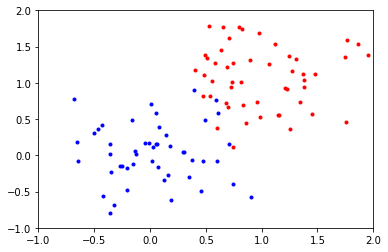

In [35]:
# Artificially make some values nan
def plot_all():
    for label, color in [(0, 'b'), (1, 'r')]:
        xy = X[labels == label]
        plt.scatter(xy[:, 0], xy[:, 1], color=color, marker='.')

    plt.axis([-1, 2, -1, 2])
    
plot_all()
plt.show()

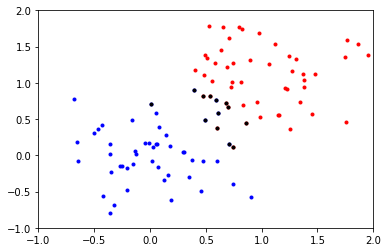

In [36]:
# Use thresholding to find some points where the clusters meet along the first principle component

from sklearn.decomposition import PCA

top_component = PCA().fit(X).components_[0]
dots = X.dot(top_component)
pca_margin = dots - dots.mean()
plot_all()
max_margin = dots.std() / 3

threshold = np.bitwise_and(-max_margin < pca_margin, pca_margin < max_margin)

xy = X[threshold]
plt.scatter(xy[:, 0], xy[:, 1], color='black', marker='.')  
plt.show()

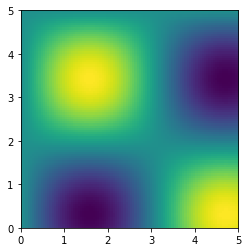

In [37]:
# Contour plots
# How to plot sin(x)*sin(y) heatmap?

xs, ys = np.mgrid[0:5:100j, 0:5:100j] # genertate mesh
Z = np.sin(xs) * np.sin(ys)
plt.imshow(Z, extent=(0, 5, 0, 5))
plt.show()

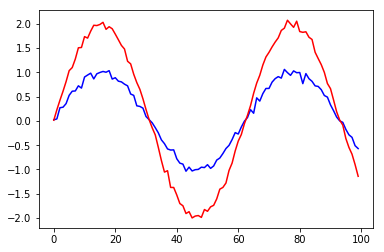

In [38]:
# Actual problem from my research:

# Suppose you have 2 sensors, each of which should take measurements
# at even intervals over the day. We want to make a method which can let us
# recover from device failure: if a sensor goes down for an extended period,
# can we impute the missing values from the other?

# Take for example two strongly correlated measured signals:

np.random.seed(1234)
s1 = np.sin(np.linspace(0, 10, 100)) + np.random.randn(100) * 0.05
s2 = 2 * np.sin(np.linspace(0, 10, 100)) + np.random.randn(100) * 0.05
plt.plot(s1, color='blue')
plt.plot(s2, color='red')
plt.show()

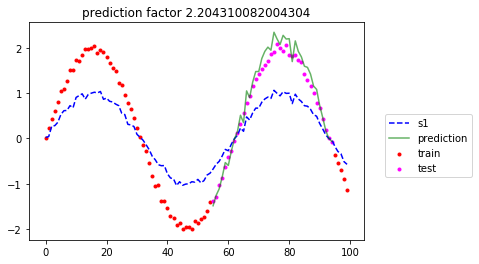

In [39]:
# Simulate a failure in sensor 2 for a random 40-index period

def holdout(): # gives arbitrary slice from 0 to 100 width 40
    width = 40
    start = np.random.randint(0, len(s2) - width)
    missing = slice(start, start + width)
    return missing, np.r_[:start, missing.stop:len(s2)]

# Find the most likely scaling for reconstructing s2 from s1
def factor_finder(train_ix):
    return np.mean((s2[train_ix] + 0.0001) / (s1[train_ix] + 0.0001))

test, train = holdout()
f = factor_finder(train)

def plot_factor(factor):
    times = np.arange(len(s1))
    test, train = holdout()
    plt.plot(times, s1, color='blue', ls='--', label='s1')
    plt.scatter(times[train], s2[train], color='red', marker='.', label='train')
    plt.plot(times[test], s1[test] * factor, color='green', alpha=0.6, label='prediction')
    plt.scatter(times[test], s2[test], color='magenta', marker='.', label='test')
    plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2)
    plt.title('prediction factor {}'.format(factor))
    plt.show()

plot_factor(f)

In [40]:
# Cubic kernel convolution and interpolation
# Complicated example; take a look on your own time!

import scipy

# From Cubic Convolution Interpolation (Keys 1981)
# Computes a piecewise cubic kernel evaluated at each data point in x
def cubic_kernel(x):
    y = np.zeros_like(x)
    x = np.fabs(x)
    if np.any(x > 2):
        raise ValueError('only absolute values <= 2 allowed')
    q = x <= 1
    y[q] = ((1.5 * x[q] - 2.5) * x[q]) * x[q] + 1
    q = ~q
    y[q] = ((-0.5 * x[q] + 2.5) * x[q] - 4) * x[q] + 2
    return y

# Everything is 1D
# Given a uniform grid of size grid_size
# and requested samples of size n_samples,
# generates an n_samples x grid_size interpolation matrix W
# such that W.f(grid) ~ f(samples) for differentiable f and samples
# inside of the grid.
def interp_cubic(grid, samples):
    delta = grid[1] - grid[0]
    factors = (samples - grid[0]) / delta
    # closest refers to the closest grid point that is smaller
    idx_of_closest = np.floor(factors)
    dist_to_closest = factors - idx_of_closest # in units of delta

    grid_size = len(grid)
    n_samples = len(samples)
    csr = scipy.sparse.csr_matrix((n_samples, grid_size), dtype=float)
    for conv_idx in range(-2, 2): # sliding convolution window
        coeff_idx = idx_of_closest - conv_idx
        coeff_idx[coeff_idx < 0] = 0 # threshold (no wraparound below)
        coeff_idx[coeff_idx >= grid_size] = grid_size - 1 # threshold (no wraparound above)
        
        relative_dist = dist_to_closest + conv_idx
        data = cubic_kernel(relative_dist)
        col_idx = coeff_idx
        ind_ptr = np.arange(0, n_samples + 1)
        csr += scipy.sparse.csr_matrix((data, col_idx, ind_ptr),
                                       shape=(n_samples, grid_size))
    return csr
    
lo, hi = 0, 1
fine = np.linspace(lo, hi, 100)
coarse = np.linspace(lo, hi, 15)
W = interp_cubic(coarse, fine)
W.shape

(100, 15)

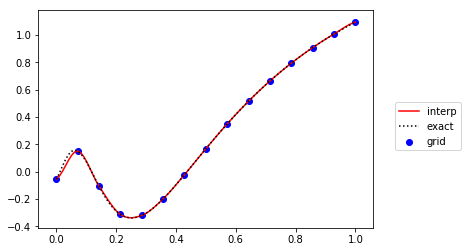

In [41]:
def f(x):
    a = np.sin(2 / (x + 0.2)) * (x + 0.1)
    # a = a * np.cos(5 * x)
    # a = a * np.cos(2 * x)
    return a

known = f(coarse) # only use coarse
interp = W.dot(known)

plt.scatter(coarse, known, color='blue', label='grid')
plt.plot(fine, interp, color='red', label='interp')
plt.plot(fine, f(fine), color='black', label='exact', ls=':')
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2)
plt.show()

# Array Creation and Initialization

[doc](https://docs.scipy.org/doc/numpy-dev/reference/routines.array-creation.html)

If unspecified, default dtype is usually float, with an exception for arange.

In [42]:
display('np.linspace(4, 8, 2)')
display('np.arange(4, 8, 2)') # GOTCHA

np.linspace(4, 8, 2) (2,)
[ 4.  8.]

np.arange(4, 8, 2) (2,)
[4 6]



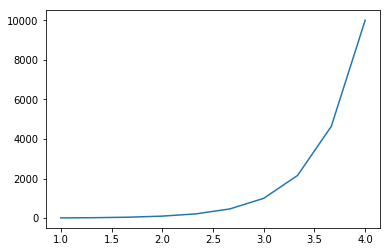

In [43]:
plt.plot(np.linspace(1, 4, 10), np.logspace(1, 4, 10))
plt.show()

In [44]:
shape = (4, 2)
print(np.zeros(shape)) # init to zero. Use np.ones or np.full accordingly

# [GOTCHA] np.empty won't initialize anything; it will just grab the first available chunk of memory
x = np.zeros(shape)
x[0] = [1, 2]
del x
print(np.empty(shape))

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
[[ 1.  2.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


In [45]:
# From iterator/list/array - can just use constructor
np.array([[1, 2], range(3, 5), np.array([5, 6])]) # auto-flatten (if possible)

array([[1, 2],
       [3, 4],
       [5, 6]])

In [46]:
# Deep copies & shape/dtype preserving creations
x = np.arange(4).reshape(2, 2)
y = np.copy(x)
z = np.zeros_like(x)
x[1, 1] = 5
print(x)
print(y)
print(z)

[[0 1]
 [2 5]]
[[0 1]
 [2 3]]
[[0 0]
 [0 0]]


Extremely extensive [random generation](https://docs.scipy.org/doc/numpy/reference/routines.random.html). Remember to seed!

# Transposition

**Under the hood**. So far, we've just been looking at the abstraction that NumPy offers. How does it actually keep things contiguous in memory?

We have a base array, which is one long contiguous array from 0 to size - 1.

In [47]:
x = np.arange(2 * 3 * 4).reshape(2, 3, 4)
print(x.shape)
print(x.size)

(2, 3, 4)
24


In [48]:
# Use ravel() to get the underlying flat array. np.flatten() will give you the original
print(x)
print(x.ravel())

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [49]:
# np.transpose or *.T will reverse axes
print('transpose', x.shape, '->', x.T.shape)
# rollaxis pulls the argument axis to axis 0, keeping all else the same.
print('rollaxis', x.shape, '->', np.rollaxis(x, 1, axis=0).shape)

print()
# all the above are instances of np.moveaxis
# it's clear how these behave:

perm = np.array([0, 2, 1])
moved = np.moveaxis(x, range(3), perm)

print('arbitrary permutation', list(range(3)), perm)
print(x.shape, '->', moved.shape)
print('moved[1, 2, 0]', moved[1, 2, 0], 'x[1, 0, 2]', x[1, 0, 2])

transpose (2, 3, 4) -> (4, 3, 2)
rollaxis (2, 3, 4) -> (3, 2, 4)

arbitrary permutation [0, 1, 2] [0 2 1]
(2, 3, 4) -> (2, 4, 3)
moved[1, 2, 0] 14 x[1, 0, 2] 14


In [50]:
# When is transposition useful?
# Matrix stuff, mostly:
np.random.seed(1234)

X = np.random.randn(3, 4)
print('sigma {:.2f}, eig {:.2f}'.format(
    np.linalg.svd(X)[1].max(),
    np.sqrt(np.linalg.eigvalsh(X.dot(X.T)).max())))

sigma 3.19, eig 3.19


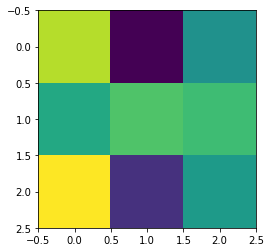

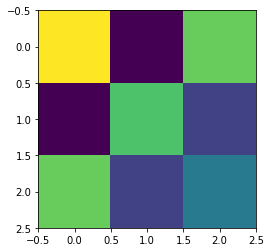

Check frob norm upper vs lower tri 0.0


In [51]:
# Create a random symmetric matrix
X = np.random.randn(3, 3)
plt.imshow(X)
plt.show()

X += X.T
plt.imshow(X)
plt.show()

print('Check frob norm upper vs lower tri', np.linalg.norm(np.triu(X) - np.tril(X).T))

In [52]:
# Row-major, C-order
# largest axis changes fastest
A = np.arange(2 * 3).reshape(2, 3).copy(order='C')

# Row-major, Fortran-order
# smallest axis changes fastest
# GOTCHA: many numpy funcitons assume C ordering
B = np.arange(2 * 3).reshape(2, 3).copy(order='F')

# Differences in representation don't manifest in abstraction
print(A)
print(B)

[[0 1 2]
 [3 4 5]]
[[0 1 2]
 [3 4 5]]


In [53]:
# Array manipulation functions with order option
# will use C/F ordering, but this is independent of the underlying layout
print(A.ravel())
print(A.ravel(order='F'))

# Reshape ravels an array, then folds back into shape, according to the given order
# Note reshape can infer one dimension; we leave it as -1.
print(A.ravel(order='F').reshape(-1, 3))
print(A.ravel(order='F').reshape(-1, 3, order='F'))

[0 1 2 3 4 5]
[0 3 1 4 2 5]
[[0 3 1]
 [4 2 5]]
[[0 1 2]
 [3 4 5]]


In [54]:
# GOTCHA: ravel will copy the array so that everything is contiguous
# if the order differs
print(id(A.base), id(A.ravel().base), id(A.ravel(order='F').base))

140168336002256 140166809085312 140168336002256


### Transposition Example: Kronecker multiplication

Based on Saatci 2011 (PhD thesis).

Recall the tensor product over vector spaces $V \otimes W$ from before. If $V$ has basis $\textbf{v}_i$ and $W$ has $\textbf{w}_j$, we can define the tensor product over elements $\nu\in V,\omega\in W$ as follows.

Let $\nu= \sum_{i=1}^n\nu_i\textbf{v}_i$ and $\omega= \sum_{j=1}^m\omega_j\textbf{w}_j$. Then:
$$
V \otimes W\ni \nu\otimes \omega=\sum_{i=1}^n\sum_{j=1}^m\nu_i\omega_j(\textbf{v}_i\otimes \textbf{w}_j)
$$

If $V$ is the vector space of $a\times b$ matrices, then its basis vectors correspond to each of the $ab$ entries. If $W$ is the vector space of $c\times d$ matrices, then its basis vectors correspond similarly to the $cd$ entries. In the tensor product, $(\textbf{v}_i\otimes \textbf{w}_j)$ is the basis vector for an entry in the $ac\times bd$ matrices that make up $V\otimes W$.

<class 'numpy.ndarray'>


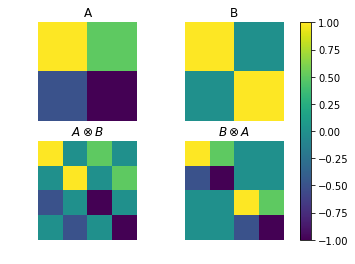

In [55]:
# Kronecker demo

A = np.array([[1, 1/2], [-1/2, -1]])
B = np.identity(2)

f, axs = plt.subplots(2, 2)

# Guess what a 2x2 axes subplot type is?
print(type(axs))
# Use of numpy for convenience: arbitrary object flattening
for ax in axs.ravel():
    ax.axis('off')
    
ax1, ax2, ax3, ax4 = axs.ravel()

ax1.imshow(A, vmin=-1, vmax=1)
ax1.set_title('A')
ax2.imshow(B, vmin=-1, vmax=1)
ax2.set_title('B')
ax3.imshow(np.kron(A, B), vmin=-1, vmax=1)
ax3.set_title(r'$A\otimes B$')
im = ax4.imshow(np.kron(B, A), vmin=-1, vmax=1)
ax4.set_title(r'$B\otimes A$')

f.colorbar(im, ax=axs.ravel().tolist())
plt.axis('off')
plt.show()

In [56]:
# Transposition demo: using transpose, you can compute

A = np.random.randn(40, 40)
B = np.random.randn(40, 40)
AB = np.kron(A, B)
z = np.random.randn(40 * 40)

def kron_mvm():
    return AB.dot(z)

def saatci_mvm():
    # This differs from the paper's MVM, but is the equivalent for
    # a C-style ordering of arrays.
    x = z.copy()
    for M in [B, A]:
        n = M.shape[1]
        x = x.reshape(-1, n).T
        x = M.dot(x)
    return x.ravel()

print('diff', np.linalg.norm(kron_mvm() - saatci_mvm()))
print('Kronecker matrix vector multiplication')
compare_times(kron_mvm, saatci_mvm)

diff 8.58998297074e-13
Kronecker matrix vector multiplication
    format: mean seconds (standard error) 5 runs
    kron_mvm   1.14e-03 (1.20e-04)
    saatci_mvm 3.56e-05 (6.43e-06)
    improvement ratio 32.1


# Ufuncs and Broadcasting

[doc](https://docs.scipy.org/doc/numpy-dev/reference/ufuncs.html)

In [57]:
# A ufunc is the most common way to modify arrays

# In its simplest form, an n-ary ufunc takes in n numpy arrays
# of the same shape, and applies some standard operation to "parallel elements"

a = np.arange(6)
b = np.repeat([1, 2], 3)
print(a)
print(b)
print(a + b)
print(np.add(a, b))

[0 1 2 3 4 5]
[1 1 1 2 2 2]
[1 2 3 5 6 7]
[1 2 3 5 6 7]


In [58]:
# If any of the arguments are of lower dimension, they're prepended with 1
# Any arguments that have dimension 1 are repeated along that axis

A = np.arange(2 * 3).reshape(2, 3)
b = np.arange(2)
c = np.arange(3)
for i in ['A', 'b', 'c']:
    display(i)

A (2, 3)
[[0 1 2]
 [3 4 5]]

b (2,)
[0 1]

c (3,)
[0 1 2]



In [59]:
# On the right, broadcasting rules will automatically make the conversion
# of c, which has shape (3,) to shape (1, 3)
display('A * c')
display('c.reshape(1, 3)')
display('np.repeat(c.reshape(1, 3), 2, axis=0)')

A * c (2, 3)
[[ 0  1  4]
 [ 0  4 10]]

c.reshape(1, 3) (1, 3)
[[0 1 2]]

np.repeat(c.reshape(1, 3), 2, axis=0) (2, 3)
[[0 1 2]
 [0 1 2]]



In [60]:
display('np.diag(c)')
display('A.dot(np.diag(c))')

np.diag(c) (3, 3)
[[0 0 0]
 [0 1 0]
 [0 0 2]]

A.dot(np.diag(c)) (2, 3)
[[ 0  1  4]
 [ 0  4 10]]



In [61]:
# GOTCHA: this won't compile your code to C: it will just make a slow convenience wrapper
demo = np.frompyfunc('f({}, {})'.format, 2, 1)

In [62]:
# GOTCHA: common broadcasting mistake -- append instead of prepend
display('A')
display('b')
try:
    demo(A, b) # can't prepend to (2,) with 1 to get something compatible with (2, 3)
except ValueError as e:
    print('ValueError!')
    print(e)

A (2, 3)
[[0 1 2]
 [3 4 5]]

b (2,)
[0 1]

ValueError!
operands could not be broadcast together with shapes (2,3) (2,) 


In [63]:
# np.newaxis adds a 1 in the corresponding axis
display('b[:, np.newaxis]')
display('np.repeat(b[:, np.newaxis], 3, axis=1)')
display('demo(A, b[:, np.newaxis])')
# note broadcasting rules are invariant to order
# even if the ufunc isn't 
display('demo(b[:, np.newaxis], A)')

b[:, np.newaxis] (2, 1)
[[0]
 [1]]

np.repeat(b[:, np.newaxis], 3, axis=1) (2, 3)
[[0 0 0]
 [1 1 1]]

demo(A, b[:, np.newaxis]) (2, 3)
[['f(0, 0)' 'f(1, 0)' 'f(2, 0)']
 ['f(3, 1)' 'f(4, 1)' 'f(5, 1)']]

demo(b[:, np.newaxis], A) (2, 3)
[['f(0, 0)' 'f(0, 1)' 'f(0, 2)']
 ['f(1, 3)' 'f(1, 4)' 'f(1, 5)']]



In [64]:
# Using broadcasting, we can do cheap diagonal matrix multiplication
display('b')
display('np.diag(b)')
# without representing the full diagonal matrix.
display('b[:, np.newaxis] * A')
display('np.diag(b).dot(A)')

b (2,)
[0 1]

np.diag(b) (2, 2)
[[0 0]
 [0 1]]

b[:, np.newaxis] * A (2, 3)
[[0 0 0]
 [3 4 5]]

np.diag(b).dot(A) (2, 3)
[[0 0 0]
 [3 4 5]]



In [65]:
# (Binary) ufuncs get lots of efficient implementation stuff for free
a = np.arange(4)
b = np.arange(4, 8)
display('demo.outer(a, b)')
display('np.bitwise_or.accumulate(b)')
display('np.bitwise_or.reduce(b)') # last result of accumulate

demo.outer(a, b) (4, 4)
[['f(0, 4)' 'f(0, 5)' 'f(0, 6)' 'f(0, 7)']
 ['f(1, 4)' 'f(1, 5)' 'f(1, 6)' 'f(1, 7)']
 ['f(2, 4)' 'f(2, 5)' 'f(2, 6)' 'f(2, 7)']
 ['f(3, 4)' 'f(3, 5)' 'f(3, 6)' 'f(3, 7)']]

np.bitwise_or.accumulate(b) (4,)
[4 5 7 7]

np.bitwise_or.reduce(b) ()
7



In [66]:
def setup(): return np.arange(10 ** 6)

def manual_accum(x):
    res = np.zeros_like(x)
    for i, v in enumerate(x):
        res[i] = res[i-1] | v
        
def np_accum(x):
    np.bitwise_or.accumulate(x)
    
print('accumulation speed comparison')
compare_times(manual_accum, np_accum, setup, setup)

accumulation speed comparison
    format: mean seconds (standard error) 5 runs
    manual_accum 2.95e-01 (2.00e-02)
    np_accum     1.78e-03 (9.77e-06)
    improvement ratio 165.6


# Aliasing

You can save on allocations and copies by providing the output array to copy into.

**Aliasing** occurs when all or part of the input is repeated in the output

[Ufuncs allow aliasing](https://github.com/numpy/numpy/pull/8043)

In [67]:
# Example: generating random symmetric matrices
A = np.random.randint(0, 10, size=(3,3))
print(A)
A += A.T # this operation is WELL-DEFINED, even though A is changing
print(A)

[[3 5 0]
 [7 7 9]
 [4 0 8]]
[[ 6 12  4]
 [12 14  9]
 [ 4  9 16]]


In [68]:
# Above is sugar for
np.add(A, A, out=A)

array([[12, 24,  8],
       [24, 28, 18],
       [ 8, 18, 32]])

In [69]:
x = np.arange(10)
print(x)
np.subtract(x[:5], x[5:], x[:5])
print(x)

[0 1 2 3 4 5 6 7 8 9]
[-5 -5 -5 -5 -5  5  6  7  8  9]


**[GOTCHA]: If it's not a ufunc, aliasing is VERY BAD**: [search for "In general the rule"](https://github.com/numpy/numpy/issues/8440).

In [70]:
x = np.arange(2 * 2).reshape(2, 2)
try:
    x.dot(np.arange(2), out=x)
    # GOTCHA: some other functions won't warn you!
except ValueError as e:
    print(e)

output array is not acceptable (must have the right type, nr dimensions, and be a C-Array)


# Configuration and Hardware Acceleration

NumPy works quickly because it can perform vectorization by linking to C functions that were built for **your** particular system.

**[GOTCHA] There are two different high-level ways in which NumPy uses hardware to accelerate your computations**.

### Ufunc

When you perform a built-in ufunc:
* The corresponding C function is called directly from the Python interpreter
* The code being run was either compiled on your system or pre-built for it, so it _should_ be vectorized
* It is **vectorized** but not **parallelized**

In general, it is tough to check whether your code is using vectorized instructions (or, in particular, which instruction set is being used, like SSE or AVX512.

* If you have a common platform and use Anaconda, you're probably fine.
* If you compiled NumPy yourself (and select the correct flags), you're probably fine.
* If have access to `icc` and MKL, then you can use [the Intel guide](https://software.intel.com/en-us/articles/numpyscipy-with-intel-mkl) or [Anaconda](https://docs.continuum.io/mkl-optimizations/)

### BLAS

These are optimized linear algebra routines, and are only called when you invoke operations that rely on these routines.

This won't make your vectors add faster (first, NumPy doesn't ask BLAS to nor could it, since bandwidth-limited ops are not the focus of BLAS). It will help with:
* Matrix multiplication (`np.dot`)
* Linear algebra (SVD, eigenvalues, etc) (`np.linalg`)
* Similar stuff from other libraries that accept NumPy arrays may use BLAS too.

There are different implementations for BLAS. Some are free, and some are proprietary and built for specific chips (MKL). You can check which version you're using [this way](http://stackoverflow.com/questions/9000164/how-to-check-blas-lapack-linkage-in-numpy-scipy), though you can only be sure [by inspecting the binaries manually](http://stackoverflow.com/questions/37184618/find-out-if-which-blas-library-is-used-by-numpy).

# Stuff to Avoid

NumPy has some cruft left over due to backwards compatibility. There are some edge cases when you would (maybe) use these things (but probably not). In general, avoid them:

* `np.chararray`: use an `np.ndarray` with `unicode` `dtype`
* `np.MaskedArrays`: use a boolean advanced index
* `np.matrix`: use a 2-dimensional `np.ndarray`

# Stuff Not Mentioned

* [General array manipulation](https://docs.scipy.org/doc/numpy-dev/reference/routines.array-manipulation.html)
    * Selection-related convenience methods `np.sort, np.unique`
    * Array composition and decomposition `np.split, np.stack`
    * Reductions many-to-1 `np.sum, np.prod, np.count_nonzero`
    * Many-to-many array transformations `np.fft, np.linalg.cholesky`
* [String formatting](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array2string.html) `np.array2string`
* [IO](https://docs.scipy.org/doc/numpy/reference/routines.io.html#string-formatting) `np.loadtxt, np.savetxt`
* [Polynomial interpolation](https://docs.scipy.org/doc/numpy/reference/routines.polynomials.html) and related [scipy integration](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html)
* [Equality testing](https://docs.scipy.org/doc/numpy/reference/routines.testing.html)

# Takeaways

* Use NumPy arrays for a compact, cache-friendly, in-memory representation of structured numeric data.
* Vectorize, vectorize, vectorize! Less loops!
   * Expressive
   * Fast
   * Concise
* Know when copies happen vs. when views happen
   * Advanced indexing -> copy
   * Basic indexing -> view
   * Transpositions -> usually view (depends if memory order changes)
   * Ufuncs/many-to-many -> copy (possibly with overwrite
* Rely on powerful indexing API to avoid almost all Python loops
* Rolling your own algorithm? Google it, NumPy probably has it built-in!
* Be concious of what makes copies, and what doesn't

Downsides. Can't optimize across NumPy ops (like a C compiler would/numpy would). But do you need that? Can't parallelize except BLAS, but is it computaitonal or memory bandwidth limited?



# Cherry on Top: Einsum

[doc](https://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html)

Recall the Kronecker product $\otimes$ from before? Let's recall the fully general tensor product.

If $V$ has basis $\textbf{v}_i$ and $W$ has $\textbf{w}_j$, we can define the tensor product over elements $\nu\in V,\omega\in W$ as follows.

Let $\nu= \sum_{i=1}^n\nu_i\textbf{v}_i$ and $\omega= \sum_{j=1}^m\omega_j\textbf{w}_j$. Then:
$$
V \otimes W\ni \nu\otimes \omega=\sum_{i=1}^n\sum_{j=1}^m\nu_i\omega_j(\textbf{v}_i\otimes \textbf{w}_j)
$$

But what if $V$ is itself a tensor space, like a matrix space $F^{m\times n}$, and $W$ is $F^{n\times k}$. Then $\nu\otimes\omega$ is a tensor with shape $(m, n, n, k)$, where the $(i_1, i_2,i_3,i_4)$-th element is given by $\nu_{i_1i_2}\omega_{i_3i_4}$ (the corresponding cannonical basis vector being $\textbf{e}^{(m)}_{i_1}(\textbf{e}^{(n)}_{i_2})^\top\otimes \textbf{e}^{(n)}_{i_3}(\textbf{e}^{(k)}_{i_4})^\top$, where $\textbf{e}^{(m)}_{i_1}(\textbf{e}^{(n)}_{i_2})^\top$, the cannonical matrix basis vector, is not that scary - here's an example in $2\times 3$:
$$
\textbf{e}^{(2)}_{1}(\textbf{e}^{(3)}_{2})^\top=\begin{pmatrix} 0 & 1 & 0\\ 0 & 0 & 0 \end{pmatrix}
$$

What happens if we **contract** along the second and third axis, both of which have length $n$, where **contraction** in this example builds a tensor with shape $(m, k)$ such that the $(i_1,i_4)$-th entry is the sum of all entries in the tensor product $\nu\otimes \omega$ which have the same values $i_2=i_3$. In other words:
$$
[\text{contract}_{12}(\nu\otimes\omega)]_{i_1i_4}=\sum_{i_2=1}^n(\nu\otimes\omega)_{i_1,i_2,i_2,i_4}=\sum_{i_2=1}^n\nu_{i_1i_2}\omega_{i_2,i_4}
$$

Does that last term look familiar? It is, it's the matrix product! Indeed, **a matrix product is a generalized trace of the outer product of two compatible matrices**.

That's one way of thinking about einsum: it lets you do generalized matrix products; in that you take in an arbitrary number of matrices, compute their outer product, and then specify which axes to trace. But then it also lets you arbitrarily transpose and select diagonal elements of your tensors, too.

In [71]:
# Great resources to learn einsum:
# https://obilaniu6266h16.wordpress.com/2016/02/04/einstein-summation-in-numpy/
# http://ajcr.net/Basic-guide-to-einsum/

# Examples of how it's general:

np.random.seed(1234)
x = np.random.randint(-10, 11, size=(2, 2, 2))
print(x)

[[[ 5  9]
  [-4  2]]

 [[10  5]
  [ 7 -1]]]


In [72]:
# Swap axes
print(np.einsum('ijk->kji', x))

[[[ 5 10]
  [-4  7]]

 [[ 9  5]
  [ 2 -1]]]


In [73]:
# Sum [contraction is along every axis]
print(x.sum(), np.einsum('ijk->', x))

33 33


In [74]:
# Multiply (pointwise) [take the diagonal of the outer product; don't sum]
y = np.random.randint(-10, 11, size=(2, 2, 2))
np.array_equal(x * y, np.einsum('ijk,ijk->ijk', x, y))

True

In [75]:
# Already, an example where einsum is more clear: multiply pointwise along different axes:
print(np.array_equal(x * y.transpose(), np.einsum('ijk,kji->ijk', x, y)))
print(np.array_equal(x * np.rollaxis(y, 2), np.einsum('ijk,jki->ijk', x, y)))

True
True


In [76]:
# Outer (tensor) product
x = np.arange(4)
y = np.arange(4, 8)
np.array_equal(np.outer(x, y), np.einsum('i,j->ij', x, y))

True

In [77]:
# Arbitrary inner product
a = np.arange(2 * 2).reshape(2, 2)
print(np.linalg.norm(a, 'fro') ** 2, np.einsum('ij,ij->', a, a))

14.0 14


In [78]:
np.random.seed(1234)
x = np.random.randn(2, 2)
y = np.random.randn(2, 2)

# Matrix multiply
print(np.array_equal(x.dot(y), np.einsum('ij,jk->ik', x, y)))

# Batched matrix multiply
x = np.random.randn(3, 2, 2)
y = np.random.randn(3, 2, 2)
print(np.array_equal(
    np.array([i.dot(j) for i, j in zip(x, y)]),
    np.einsum('bij,bjk->bik', x, y)))

# all of {np.matmul, np.tensordot, np.dot} are einsum instances
# The specializations may have marginal speedups, but einsum is
# more expressive and clear code.

True
True


### General Einsum Approach

Again, lots of visuals in [this blog post](https://obilaniu6266h16.wordpress.com/2016/02/04/einstein-summation-in-numpy/).

**[GOTCHA]**. [You can't use more than 52 different letters.](http://stackoverflow.com/questions/37794245/can-i-use-more-than-26-letters-in-numpy-einsum). But if you find yourself writing `np.einsum` with more than 52 active dimensions, you should probably make two `np.einsum` calls. If you have dimensions for which nothing happens, then `...` can be used to represent an arbitrary amount of missed dimensions.

Here's the way I think about an `np.einsum` (the actual implementation is more efficient).

In [79]:
# Let the contiguous blocks of letters be words
# If they're on the left, they're argument words. On the right, result words.

np.random.seed(1234)
x = np.random.randint(-10, 11, 3 * 2 * 2 * 1).reshape(3, 2, 2, 1)
y = np.random.randint(-10, 11, 3 * 2 * 2).reshape(3, 2, 2)
z = np.random.randint(-10, 11, 2 * 3).reshape(2, 3)

# Example being followed in einsum description:
# np.einsum('ijkm,iko,kp->mip', x, y, z)

# 1. Line up each argument word with the axis of the array.
#    Make sure that word length == dimension
#    Make sure same letters correspond to same lengths
# x.shape (3, 2, 2, 1)
#          i  j  k  m
# y.shape (3, 2, 2)
#          i  k  o
# z.shape (2, 3)
#          k  p

In [80]:
# 2. Create the complete tensor product
outer = np.tensordot(np.tensordot(x, y, axes=0), z, axes=0)
print(outer.shape)
print('(i  j  k  m  i  k  o  k  p)')

(3, 2, 2, 1, 3, 2, 2, 2, 3)
(i  j  k  m  i  k  o  k  p)


In [81]:
# 3. Every time a letter repeats, only look at the corresponding "diagonal" elements.

# Repeat i: (i  j  k  m  i  k  o  k  p)
#           (i           i            )
# Expected: (i  j  k  m  k  o  k  p)

# The expected index corresponds to the above index in the outer product
# We can do this over all other values with two advanced indices
span_i = np.arange(3)
repeat_i = outer[span_i, :, :, :, span_i, ...] # ellipses means "fill with :"
print(repeat_i.shape)
print('(i  j  k  m  k  o  k  p)')

# Repeat k: (i  j  k  m  k  o  k  p)
#           (      k     k     k   )
# Expected: (i  j  k  m  o  p)
span_k = np.arange(2)
repeat_k = repeat_i[:, :, span_k, :, span_k, :, span_k, :]
# GOTCHA: advanced indexing brings shared advanced index to front, fixed with rollaxis
repeat_k = np.rollaxis(repeat_k, 0, 2)
print(repeat_k.shape)
print('(i  j  k  m  o  p)')

(3, 2, 2, 1, 2, 2, 2, 3)
(i  j  k  m  k  o  k  p)
(3, 2, 2, 1, 2, 3)
(i  j  k  m  o  p)


In [82]:
# 4. Compare the remaining word to the result word; sum out missing letters

# Result word:  (m  i  p)
# Current word: (i  j  k  m  o  p)

# Sum out j:    (i  k  m  o  p)
# The resulting array has at entry (i k m o p) the following:
# (i 0 k m o p) + (i 1 k m o p) + ... + (i [axis j length] k m o p)
sumj = repeat_k.sum(axis=1)
print(sumj.shape)
print('(i  k  m  o  p)')

# Sum out k:    (i  m  o  p)
sumk = sumj.sum(axis=1)
print(sumk.shape)
print('(i  m  o  p)')

# Sum out o:    (i  m  p)
sumo = sumk.sum(axis=2)
print(sumo.shape)
print('(i  m  p)')

(3, 2, 1, 2, 3)
(i  k  m  o  p)
(3, 1, 2, 3)
(i  m  o  p)
(3, 1, 3)
(i  m  p)


In [83]:
# 6. Transpose remaining word until it has the same order as the result word

# (i  m  p) -> (m  i  p)
print(np.moveaxis(sumo, [0, 1, 2], [1, 0, 2]))
print(np.einsum('ijkm,iko,kp->mip', x, y, z))

[[[  808 -1006 -1139]
  [-1672   228   552]
  [  806    35  -125]]]
[[[  808 -1006 -1139]
  [-1672   228   552]
  [  806    35  -125]]]


### Neural Nets with Einsum

[Original post](https://obilaniu6266h16.wordpress.com/2016/02/04/einstein-summation-in-numpy/)

<table>
<tr>
<th>
<img src="assets/mlp1.png" alt="https://obilaniu6266h16.wordpress.com/2016/02/04/einstein-summation-in-numpy/" width="600" >
</th><th>
<img src="assets/mlp2.png" alt="https://obilaniu6266h16.wordpress.com/2016/02/04/einstein-summation-in-numpy/" width="600" >
</th></tr></table>

Notice how `np.einsum` captures succinctly the tensor flow (yep): the extension to batch is **extremely natural**. You can imagine a similar extension to RGB input (instead of a black/white float, we have an array of 3 values, so our input is now a 4D tensor `(batch_size, height, width, 3)`).

### Real Application

Under certain conditions, a kernel for a Gaussian process, a model for regression, is a matrix with the following form:
$$
K = \sum_{i=1}^nB_i\otimes D_i
$$

$B_i$ has shape $a\times a$, and they are small dense matrices. $D_i$ is a $b\times b$ diagonal matrix, and $b$ is so large that we can't even hold $b^2$ in memory. So we only have a vector to represent $D_i$. A useful operation in Gaussian process modelling is the multiplication of $K$ with a vector, $K\textbf{z}$. How can we do this efficiently and expressively?

In [84]:
np.random.seed(1234)
a = 3
b = 300
Bs = np.random.randn(10, a, a)
Ds = np.random.randn(10, b) # just the diagonal

z = np.random.randn(a * b)

def quadratic_impl():
    K = np.zeros((a * b, a * b))
    for B, D in zip(Bs, Ds):
        K += np.kron(B, np.diag(D))
    return K.dot(z)

def einsum_impl():
    # Ellipses trigger broadcasting
    left_kron_saatci = np.einsum('N...b,ab->Nab', Ds, z.reshape(a, b))
    full_sum = np.einsum('Nca,Nab->cb', Bs, left_kron_saatci)
    return full_sum.ravel()

print('L2 norm of difference', np.linalg.norm(quadratic_impl() - einsum_impl()))
# Of course, we can make this arbitrarily better by increasing b...
print('Matrix-vector multiplication')
compare_times(quadratic_impl, einsum_impl)

L2 norm of difference 4.01248792692e-14
Matrix-vector multiplication
    format: mean seconds (standard error) 5 runs
    quadratic_impl 3.68e-02 (2.12e-03)
    einsum_impl    7.26e-05 (2.42e-05)
    improvement ratio 507.0
